### Data Pre Processing:

Import libraries:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import time

Calculate actual mean and std of dataset for more accurate transformations:

In [2]:
# Workout actual mean and std of the dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = Flowers102(root='', split='train', transform=transform, download=True)

# R, G, B
channel_sum = torch.zeros(3)
channel_sum_squared = torch.zeros(3)
count = 0

for img, _ in train_dataset:
    channel_sum += torch.mean(img, dim=(1, 2))
    channel_sum_squared += torch.mean(img ** 2, dim=(1, 2))
    count += 1

mean = (channel_sum / count).numpy()
std = (torch.sqrt(channel_sum_squared / count - mean ** 2)).numpy()

print("Mean:", mean)
print("Std:", std)

Mean: [0.4329607  0.38192013 0.29637718]
Std: [0.29519516 0.24728866 0.2741795 ]


visualise image cropping to ensure too much data isn't lost:

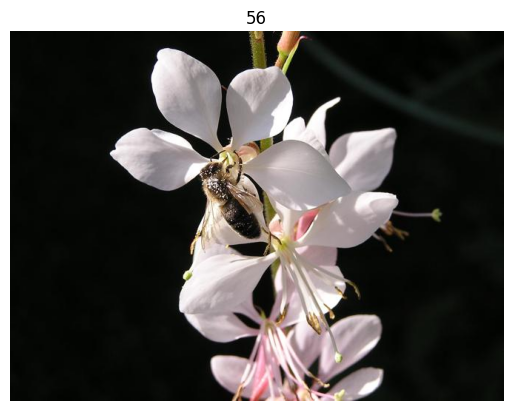

(500, 667, 3)


In [3]:
img, label = train_dataset[567]
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()
print(np_img.shape)

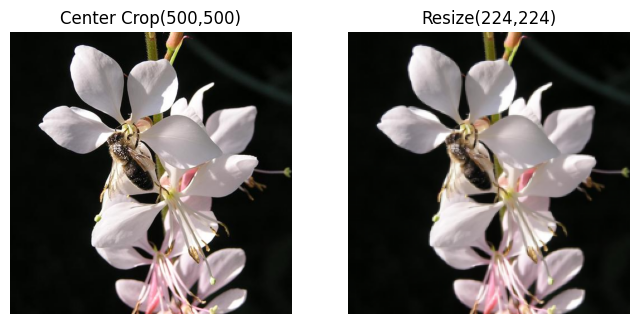

In [4]:
# imgs center cropped to 500 and then resized to 224
img, label = train_dataset[567]

center_crop_transform = transforms.CenterCrop(500)
resize_transform = transforms.Resize(224)

img_center_crop = center_crop_transform(img)
img_resize = resize_transform(img_center_crop)

np_img_center_crop = img_center_crop.permute(1, 2, 0).numpy()
np_img_resize = img_resize.permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow((np_img_center_crop * 255).astype('uint8'))
axes[0].set_title('Center Crop(500,500)')
axes[0].axis('off')
axes[1].imshow((np_img_resize * 255).astype('uint8'))
axes[1].set_title('Resize(224,224)')
axes[1].axis('off')

plt.show()

define transforms and apply transformations to data splits:

In [5]:
train_transform = transforms.Compose([
		transforms.CenterCrop((500,500)),
		transforms.Resize(size=(224,224)),
		transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.1),
		transforms.RandomRotation(90),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
		transforms.ToTensor(),
		transforms.Normalize(mean=mean, std=std),
])

transform = transforms.Compose([
		transforms.Resize((224,224)),
		transforms.ToTensor(),
		transforms.Normalize(mean=mean, std=std),
])

In [6]:
training_data = Flowers102(root='', split='train', transform=train_transform, download=False)
testing_data = Flowers102(root='',split='test',transform=transform,download=False)
evaluation_data = Flowers102(root='',split='val',transform=transform,download=False)

In [7]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


visualise data post transformations:

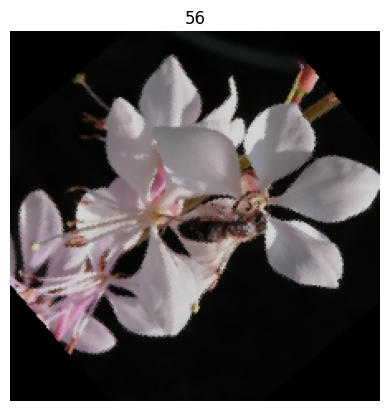

In [8]:
img, label = training_data[567] # just a random instance to see how the data has been normalised
img = (img.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
plt.title(label)
plt.imshow((img * 255).astype('uint8'))
plt.axis('off')
plt.show()

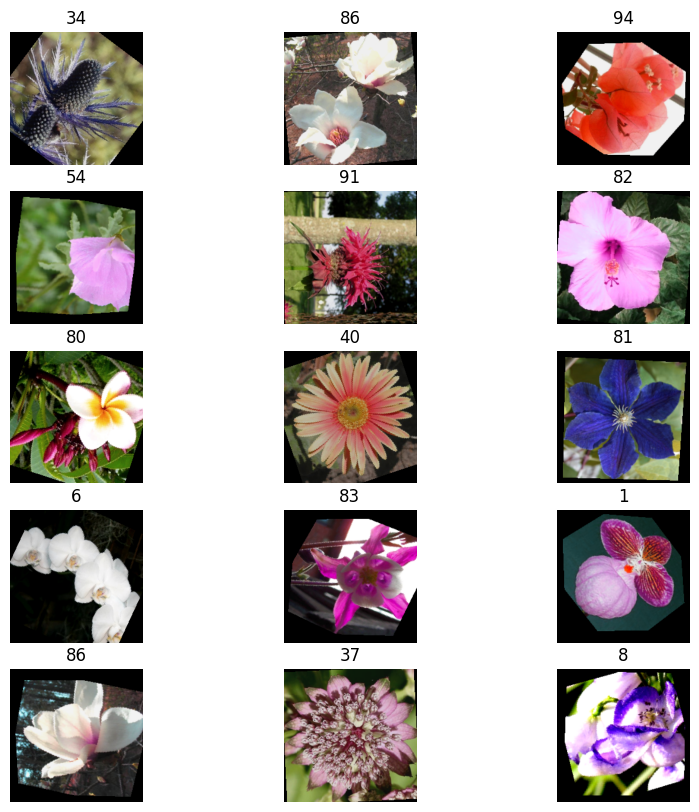

In [9]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]
	img = (img.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

### Define CNN:

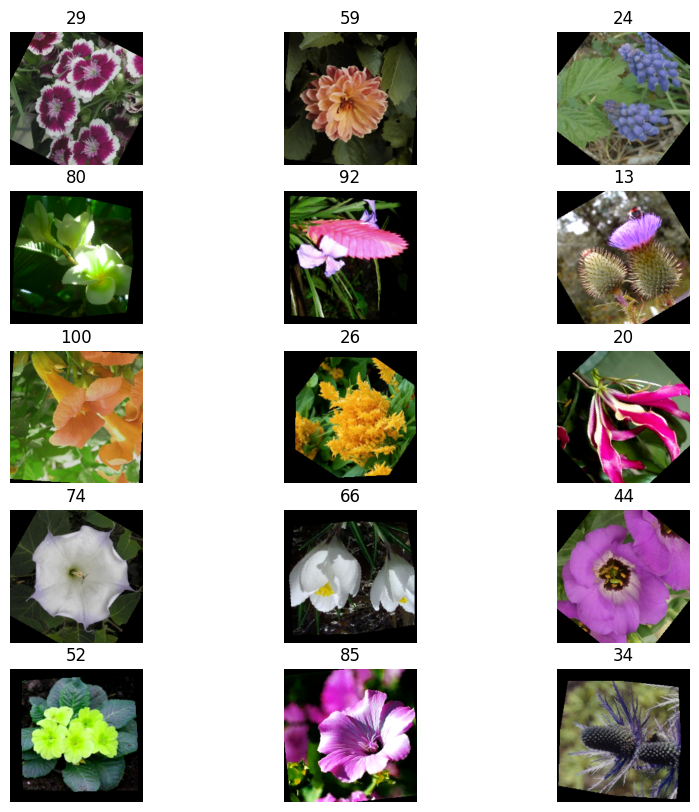

In [10]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]
	img = (img.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((img * 255).astype('uint8'))
	plt.axis('off')
plt.show()
#%%
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
			super(FlowerClassifier, self).__init__()
			self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
			self.bn1 = nn.BatchNorm2d(32)

			self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
			self.bn2 = nn.BatchNorm2d(64)

			self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
			self.bn3 = nn.BatchNorm2d(128)

			self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
			self.bn4 = nn.BatchNorm2d(256)

			self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
			self.bn5 = nn.BatchNorm2d(512)

			self.conv6 = nn.Conv2d(512, 256, kernel_size=3)
			self.bn6 = nn.BatchNorm2d(256)

			self.pool = nn.MaxPool2d(2, 2)
			self.dropout = nn.Dropout(p=0.025)
			self.flatten = nn.Flatten()
			self.fc = nn.Linear(256, 102)

	def forward(self, x):
			x = self.pool(F.relu(self.bn1(self.conv1(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn2(self.conv2(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn3(self.conv3(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn4(self.conv4(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn5(self.conv5(x))))
			x = self.dropout(x)

			x = self.pool(F.relu(self.bn6(self.conv6(x))))
			x = self.flatten(x)
			x = self.fc(x)

			return x

####Training the Data:

Get Device:

In [11]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


Graphs that visualise the training and evaluation losses after training

In [12]:
def plot_graphs(train_losses, eval_losses, eval_accuracies):
    # Plotting the training and evaluation losses
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Losses')
    plt.legend()
    plt.show()

    # Plotting the evaluation accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

#### **Train and Eval function**

In [13]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, patience=10, epochs=10):
	train_losses = []
	eval_losses = []
	eval_accuracies = []

	best_valid_loss = np.inf
	patience_counter = 0

	start_time = time.time()

	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)
		train_losses.append(training_loss)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total
		eval_losses.append(evaluation_loss)
		eval_accuracies.append(evaluation_accuracy)

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')

		if evaluation_loss < best_valid_loss:
				best_valid_loss = evaluation_loss
				patience_counter = 0
		else:
				patience_counter += 1
				if patience_counter >= patience:
						print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
						break

	end_time = time.time()
	duration_minutes = (end_time - start_time) / 60

	print(f'Training finished. Time taken: {duration_minutes:.2f} minutes')
	plot_graphs(train_losses, eval_losses, eval_accuracies)

define data loaders, batch size 64

In [19]:
training_loader = DataLoader(training_data, batch_size=16, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=16, shuffle=False)

train model:

Epoch 1/200, Training Loss: 4.5375, Evaluation Loss: 4.2079, Val Accuracy: 0.0725
Epoch 2/200, Training Loss: 4.1373, Evaluation Loss: 3.9658, Val Accuracy: 0.1235
Epoch 3/200, Training Loss: 3.9408, Evaluation Loss: 3.7876, Val Accuracy: 0.1696
Epoch 4/200, Training Loss: 3.7720, Evaluation Loss: 3.6422, Val Accuracy: 0.1882
Epoch 5/200, Training Loss: 3.6011, Evaluation Loss: 3.5007, Val Accuracy: 0.2216
Epoch 6/200, Training Loss: 3.4797, Evaluation Loss: 3.4381, Val Accuracy: 0.2627
Epoch 7/200, Training Loss: 3.3515, Evaluation Loss: 3.2778, Val Accuracy: 0.2745
Epoch 8/200, Training Loss: 3.2338, Evaluation Loss: 3.2324, Val Accuracy: 0.2569
Epoch 9/200, Training Loss: 3.1065, Evaluation Loss: 3.2065, Val Accuracy: 0.2441
Epoch 10/200, Training Loss: 3.0273, Evaluation Loss: 3.1274, Val Accuracy: 0.2892
Epoch 11/200, Training Loss: 2.9183, Evaluation Loss: 2.9409, Val Accuracy: 0.3304
Epoch 12/200, Training Loss: 2.8383, Evaluation Loss: 2.8856, Val Accuracy: 0.3392
Epoch 13/200,

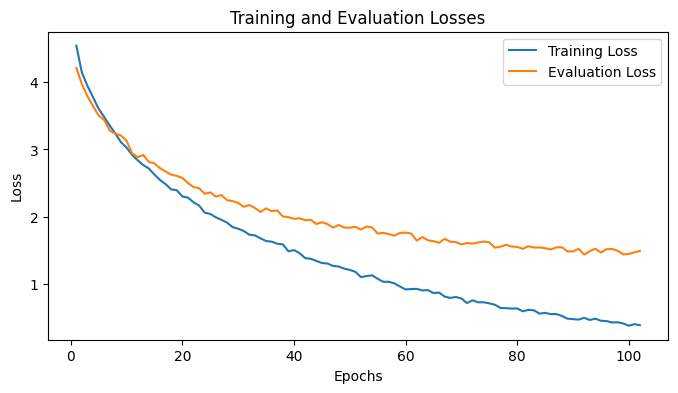

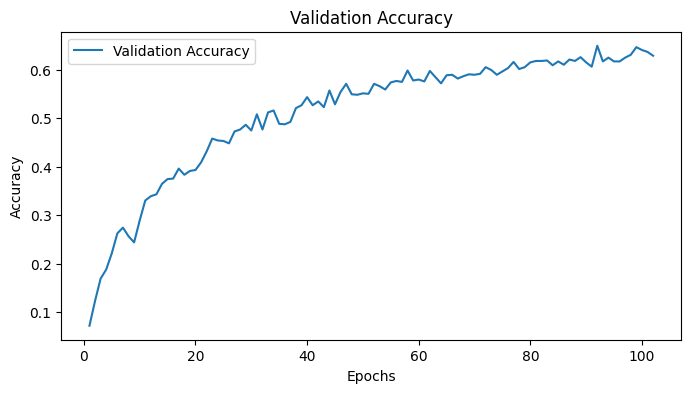

In [20]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
# maybe add weightdecay?
optimizer = optim.Adam(model.parameters(), lr=0.0001, )


train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=200)

In [21]:
torch.save(model.state_dict(), 'flowers-102.pth')

In [22]:
# visualise model architecture
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
       BatchNorm2d-2         [-1, 32, 222, 222]              64
         MaxPool2d-3         [-1, 32, 111, 111]               0
           Dropout-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 109, 109]          18,496
       BatchNorm2d-6         [-1, 64, 109, 109]             128
         MaxPool2d-7           [-1, 64, 54, 54]               0
           Dropout-8           [-1, 64, 54, 54]               0
            Conv2d-9          [-1, 128, 52, 52]          73,856
      BatchNorm2d-10          [-1, 128, 52, 52]             256
        MaxPool2d-11          [-1, 128, 26, 26]               0
          Dropout-12          [-1, 128, 26, 26]               0
           Conv2d-13          [-1, 256, 24, 24]         295,168
      BatchNorm2d-14          [-1, 256,

### Testing:

Evaluation function, of final model:

In [23]:
def evaluate(model, data_loader, criterion):
    model.eval()
    evaluation_loss = 0.0
    correct = 0
    total = 0
    misclassified_images = []
    class_counts = {}

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            evaluation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for label in labels.cpu().numpy():
                if label not in class_counts:
                    class_counts[label] = 0
                class_counts[label] += 1

            misclassified_inds = (predicted != labels).nonzero()
            for mis_ind in misclassified_inds:
                mis_img = inputs[mis_ind].cpu()
                mis_label = labels[mis_ind].cpu()
                mis_pred = predicted[mis_ind].cpu()
                misclassified_images.append((mis_img, mis_label, mis_pred))

    evaluation_loss /= len(data_loader.dataset)
    evaluation_accuracy = correct / total

    print(f'Evaluation Loss: {evaluation_loss:.4f}, Accuracy: {evaluation_accuracy*100:.4f}')

    return misclassified_images, class_counts

In [24]:
def list_misclassification_examples_per_class(misclassified_images, class_counts):
    classes_dict = {}
    total_misclassified = 0

    for _, true_label, pred_label in misclassified_images:
        true_label = true_label.item()
        pred_label = pred_label.item()
        if true_label not in classes_dict:
            classes_dict[true_label] = {"count": 0, "examples": []}
        if classes_dict[true_label]["count"] < 1:
            classes_dict[true_label]["examples"].append(pred_label)
        classes_dict[true_label]["count"] += 1
        total_misclassified += 1

    for true_label, misclassified_info in classes_dict.items():
        total_images = class_counts[true_label]
        misclassification_percentage = (misclassified_info['count'] / total_images) * 100
        print(f"True Label: {true_label}, Misclassified Count: {misclassified_info['count']}/{total_images} ({misclassification_percentage:.2f}%)")

    print(f"Total Misclassified Images: {total_misclassified}")

Test model on test data and list number of examples misclassifed per class:

In [25]:
test_loader = DataLoader(testing_data, batch_size=64, shuffle=False)

In [26]:
misclassified_images, class_counts = evaluate(model, test_loader, criterion)
list_misclassification_examples_per_class(misclassified_images, class_counts)

Evaluation Loss: 1.6446, Accuracy: 59.2617
True Label: 0, Misclassified Count: 6/20 (30.00%)
True Label: 1, Misclassified Count: 15/40 (37.50%)
True Label: 2, Misclassified Count: 15/20 (75.00%)
True Label: 3, Misclassified Count: 26/36 (72.22%)
True Label: 4, Misclassified Count: 24/45 (53.33%)
True Label: 5, Misclassified Count: 8/25 (32.00%)
True Label: 6, Misclassified Count: 8/20 (40.00%)
True Label: 7, Misclassified Count: 16/65 (24.62%)
True Label: 8, Misclassified Count: 18/26 (69.23%)
True Label: 9, Misclassified Count: 5/25 (20.00%)
True Label: 10, Misclassified Count: 52/67 (77.61%)
True Label: 11, Misclassified Count: 24/67 (35.82%)
True Label: 12, Misclassified Count: 3/29 (10.34%)
True Label: 13, Misclassified Count: 3/28 (10.71%)
True Label: 14, Misclassified Count: 14/29 (48.28%)
True Label: 15, Misclassified Count: 11/21 (52.38%)
True Label: 20, Misclassified Count: 7/20 (35.00%)
True Label: 16, Misclassified Count: 20/65 (30.77%)
True Label: 17, Misclassified Count: 3